In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from cideMOD import (
    CellParser,
    ErrorCheck,
    Problem,
    SolverCrashed,
    Trigger,
    get_model_options,
)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
overwrite = False
case = "Chen_2020"
data_path = f"../../data/data_{case}"
params = "params_tuned.json"

model_options = get_model_options(model='P2D', 
                                  clean_on_exit=False,
                                  save_path=f"results/{case}",
                                  overwrite=overwrite)

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Chen_2020


In [3]:
cell = CellParser(params, data_path, model_options)
problem = Problem(cell, model_options)
problem.set_cell_state(SoC=1, T_ini=273 + 25, T_ext=273 + 25)
problem.setup()
C_rate = -1
I_app = -5 # C_rate * cell.ref_capacity
t_f = 3600 /abs(C_rate)*1.25

Negative electrode capacity: 5.090422
Positive electrode capacity: 5.574712
Cell capacity: 5.090422
Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Building problem setup
- Building cell parameters - Done
- Initializing state - Done   
- Build variational formulation - Done 


In [4]:
v_min = Trigger(2.5, "v")
status = problem.solve(
    min_step=10, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

Voltage is 2.5 V at 59min 10s               



# Compare results

In [5]:
ref_results_path = os.path.join(data_path, 'reference_data')
voltage_data_1C = np.genfromtxt(os.path.join(ref_results_path, "V_1C_Chen.txt"), 
                                delimiter=' ')
voltage_pybamm_1C = np.genfromtxt(os.path.join(ref_results_path, "Chen_1C.csv"), 
                                  skip_header=1, delimiter=',')
cideMOD_time = problem.get_global_variable('time')
cideMOD_voltage = problem.get_global_variable('voltage')
cideMOD_capacity = problem.get_global_variable('capacity')

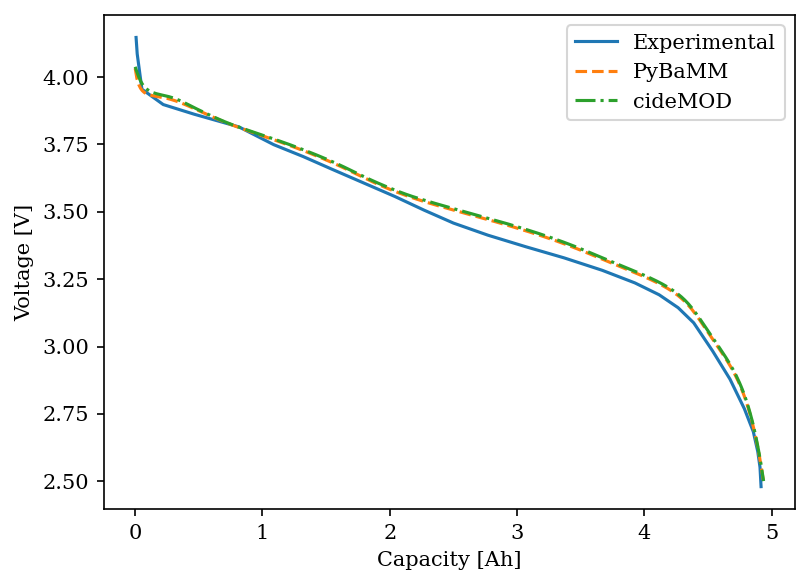

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=150)

# plot the 1C results over capacity
ax1.plot(voltage_data_1C[:,0]*5/3600, voltage_data_1C[:,1], "-", label="Experimental")
ax1.plot(voltage_pybamm_1C[:,0]*5/3600, voltage_pybamm_1C[:,2], "--", label="PyBaMM")
ax1.plot(cideMOD_capacity, cideMOD_voltage, "-.", label="cideMOD")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(loc="best")

plt.tight_layout()
plt.show()

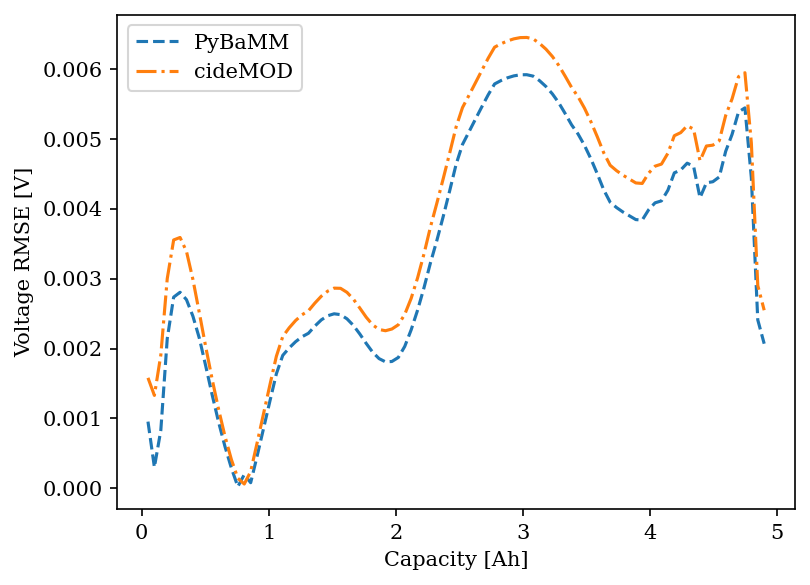

In [7]:
from scipy.interpolate import interp1d
import numpy as np
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=150)

# plot the RMSE over capacity
real = interp1d(voltage_data_1C[:,0]*5/3600, voltage_data_1C[:,1], bounds_error=False)
pybamm = interp1d(voltage_pybamm_1C[:,0]*5/3600, voltage_pybamm_1C[:,2], bounds_error=False)
cideMOD = interp1d(cideMOD_capacity, cideMOD_voltage, bounds_error=False)

capacity = np.linspace(0, 5, 100)

ax1.plot(capacity, np.sqrt((real(capacity)-pybamm(capacity))**2/len(capacity)), '--', label="PyBaMM")
ax1.plot(capacity, np.sqrt((real(capacity)-cideMOD(capacity))**2/len(capacity)), '-.', label="cideMOD")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltage RMSE [V]")
ax1.legend(loc="best")

plt.tight_layout()
plt.show()

In [8]:
from tabulate import tabulate

capacity = np.linspace(
    max(voltage_data_1C[0,0], voltage_pybamm_1C[0,0], cideMOD_time[0]), 
    min(voltage_data_1C[-1,0], voltage_pybamm_1C[-1,0], cideMOD_time[-1]), 
    100) * 5/3600

# Compute RMSE
rmse_pybamm = np.sqrt(np.sum((real(capacity)-pybamm(capacity))**2)/len(capacity))*1e3
rmse_cideMOD = np.sqrt(np.sum((real(capacity)-cideMOD(capacity))**2)/len(capacity))*1e3
peak_pybamm = np.abs(real(capacity)-pybamm(capacity)).max()*1e3
peak_cideMOD = np.abs(real(capacity)-cideMOD(capacity)).max()*1e3
print(tabulate([["RMSE (mV)", rmse_pybamm, rmse_cideMOD], 
                ["Peak error (mV)",peak_pybamm,peak_cideMOD ]], 
               headers = ['', 'PyBaMM', 'cideMOD'], floatfmt=".0f"))

                   PyBaMM    cideMOD
---------------  --------  ---------
RMSE (mV)              40         44
Peak error (mV)       134        119
